In [114]:
import numpy as np
from scipy import special  # for erf

We use the following notation.

$c_{11}, \ldots, c_{22}$ are multipliers.

$g_{11}, \ldots, g_{22}$ are Gaussian functions.

$n_{11}, \ldots, n_{22}$ are Gaussian normalizers.

$d_{11}, \ldots, d_{22}$ are orthonormalizing multipliers.

**Atomic orbitals**:

$\phi_1 = c_{11}n_{11}g_{11} + c_{12}n_{12}g_{12}$

$\phi_2 = c_{21}n_{21}g_{21} + c_{22}n_{22}g_{22}$

**Molecular orbitals**:

$\psi_1 = d_{11}\phi_1 + d_{12}\phi_2$

$\psi_2 = d_{21}\phi_1 + d_{22}\phi_2$

# Setup and Helper Functions

In [115]:
# Nuclei locations
xA = 0.0
yA = 0.0
zA = 0.0

xB = 1.4
yB = 0.0
zB = 0.0

In [116]:
def set_gaussians(A, xA, yA, zA, xB, yB, zB):
    '''
    Simple representation of the Gaussians. No calculations are done.
    
    :param A: matrix of exponent values.
    :param xA, ..., zB: nuclei coordinates.
    :return: 2 x num_primitives_per_orbital x 4 matrix where each entry represents a parametrized Gaussian.
    '''
    num_prim = A.shape[1]
    g1 = []
    g2 = []
    for k in range(num_prim):
        g1.append([-A[0,k], xA, yA, zA])
        g2.append([-A[1,k], xB, yB, zB])
    G = np.array([g1, g2])
    return G

In [117]:
# Example:
A = np.array([[1, 2, 3], [4, 5, 6]])  # Gaussian exponents
G = set_gaussians(A, xA, yA, zA, xB, yB, zB)
print(G)

[[[-1.   0.   0.   0. ]
  [-2.   0.   0.   0. ]
  [-3.   0.   0.   0. ]]

 [[-4.   1.4  0.   0. ]
  [-5.   1.4  0.   0. ]
  [-6.   1.4  0.   0. ]]]


In [118]:
# Gaussian normalizers
def normalize_gaussians(A):
    '''
    :param A: matrix of Gaussian (positive) exponents
    :return: normalizing matrix Z.
    '''
    Z = (2*A/np.pi)**(3/4)
    return Z

In [119]:
#Example:
Z = normalize_gaussians(A)
print(Z)

[[0.71270547 1.19862295 1.62461715]
 [2.01583548 2.38307437 2.73226947]]


In [120]:
def nuc_dist_sqr(RA, RB):
    '''
    :param RA, RB: triples representing nuclei locations
    :return: Square of the distance between nuclei at RA and RB
    '''
    return (RA[0]-RB[0])**2 + (RA[1]-RB[1])**2 + (RA[2]-RB[2])**2

## Orthonormalization

In [121]:
# (A.9) in text
def gg_integral(i1, i2, A, C, Z, G):
    res = 0
    num_prim = C.shape[1]
    coefs1 = []
    coefs2 = []
    funcs1 = []
    funcs2 = []
    for k in range(num_prim):
        coefs1.append(C[i1,k]*Z[i1,k])
        coefs2.append(C[i2,k]*Z[i2,k])
        funcs1.append(G[i1, k])
        funcs2.append(G[i2, k])
    
    for c1, f1 in zip(coefs1, funcs1):
        for c2, f2 in zip(coefs2, funcs2):
            a = -f1[0]
            b = -f2[0]
            RA = f1[1:]
            RB = f2[1:]
            diffAB = nuc_dist_sqr(RA, RB)
            integral = (np.pi/(a+b))**(3/2) * np.exp(-a*b*diffAB/(a+b))
            res += c1*c2*integral
    return res

In [122]:
def orth_matrix(A, C, Z, G):
    '''Given exponents A, multipliers C, normalizers Z, Gaussians functions G
    Return matrix of orthnoromalizing coefficients.
    '''
    S11 = gg_integral(0, 0, A, C, Z, G)
    S12 = gg_integral(0, 1, A, C, Z, G)
    S21 = gg_integral(1, 0, A, C, Z, G)
    S22 = gg_integral(1, 1, A, C, Z, G)
    S = np.array([[S11, S12], [S21, S22]])
    s, U = np.linalg.eig(S)
    X = U / np.sqrt(s)
    return X

In [123]:
# Example:
C = np.random.rand(2, 3)
D = orth_matrix(A, C, Z, G)
print(D)

[[-0.49437067 -0.28023194]
 [ 0.29437947 -0.4706118 ]]


In [124]:
def extract_coefs_and_funcs(i):
    '''
    :param i: value in {1,2} representing molecular orbital psi_i
    :return: (list of) coefficients and (list of) Gaussian functions representing psi_i.
    '''
    num_prim = C.shape[1]
    coefs = []
    funcs = []
    for k in range(num_prim):
        coefs.append(D[i, 0]*C[0,k]*Z[0,k])
        funcs.append(G[0,k])
    for k in range(num_prim):
        coefs.append(D[i, 1]*C[1,k]*Z[1,k])
        funcs.append(G[1,k])
    return coefs, funcs

In [125]:
extract_coefs_and_funcs(1)

([0.033840752334553366,
  0.2800874202443968,
  0.40098618285966997,
  -0.09363339989561834,
  -0.9589217712943051,
  -1.097833935113292],
 [array([-1.,  0.,  0.,  0.]),
  array([-2.,  0.,  0.,  0.]),
  array([-3.,  0.,  0.,  0.]),
  array([-4. ,  1.4,  0. ,  0. ]),
  array([-5. ,  1.4,  0. ,  0. ]),
  array([-6. ,  1.4,  0. ,  0. ])])

# Integrals

## Laplacian integrals

In [126]:
def L_integral(a, b, RA, RB):
    '''
    Compute integral corresponding to <A | (-1/2)L^2 | B> using (A.11) in the text.
    
    :param a: value of exponent in first Gaussian
    :param b: value of exponent in second Gaussian
    :param RA: center of first Gaussian (triple)
    :param RB: center of second Gaussian (triple)
    :return: the value of the integral <g(a, RA) | (-1/2)L^2 | g(b, RB)>
    '''
    diff = nuc_dist_sqr(RA, RB)
    res = a*b / (a + b)
    res *= (3-2*a*b*diff/(a+b))
    res *= (np.pi/(a+b))**(3/2)
    res *= np.exp(-a*b*diff/(a+b))
    return res

In [127]:
def Lterm(i1, i2):
    ''' 
    Computes <psi_i1 | (-1/2)L^2 | psi_i2> by iterating over the terms in the expressions.
    '''
    coefs1, funcs1 = extract_coefs_and_funcs(i1)
    coefs2, funcs2 = extract_coefs_and_funcs(i2)    
    L = 0
    for c1, f1 in zip(coefs1, funcs1):
        for c2, f2 in zip(coefs2, funcs2):
            res = L_integral(-f1[0], -f2[0], f1[1:], f2[1:])
            L += c1*c2*res
    return L

## Electron-nuclei integrals

In [128]:
def F0(t):
    if t == 0:
        return 1
    else:
        return (1/2)*(np.pi/t)**(1/2)*special.erf(t**(1/2))

def nuc_integral(a, b, RA, RB, R_nuc):
    '''
    Compute integral corresponding to <A | -1/r_1,nuc | B> using (A.33) in the text.
    
    :param a: value of exponent in first Gaussian.
    :param b: value of exponent in second Gaussian.
    :param RA: center of first Gaussian (triple).
    :param RB: center of second Gaussian (triple).
    :param R_nuc: center of the nucleus in question.
    :return: value of the integral <g(a, RA) | -r_1,nuc | g(b, RB)>.
    '''
    diffAB = nuc_dist_sqr(RA, RB)
    RP = {}
    for i in range(3):
        RP[i] = (a*RA[i]+b*RB[i])/(a+b)
    diffPC = nuc_dist_sqr(RP, R_nuc)
    res = -2*np.pi/(a+b)
    res *= np.exp(-a*b*diffAB/(a+b))
    res *= F0((a+b)*diffPC)
    return res

In [129]:
def nuc_term(i1, i2, R_nuc):
    ''' 
    Computes <psi_i1 | -1/r_1,nuc | psi_i2> by iterating over the terms in the expressions.
    '''
    coefs1, funcs1 = extract_coefs_and_funcs(i1)
    coefs2, funcs2 = extract_coefs_and_funcs(i2)
    L = 0
    for c1, f1 in zip(coefs1, funcs1):
        for c2, f2 in zip(coefs2, funcs2):
            res = nuc_integral(-f1[0], -f2[0], f1[1:], f2[1:], R_nuc)
            L += c1*c2*res
    return L

## Electron-electron integrals

In [130]:
def ee_integral(a, b, c, d, RA, RB, RC, RD, RP, RQ):
    '''
    Computes the electron-electron integral as in (A.41) in the text.
    
    :param a, b, c, d: first/second/third/fourth Gaussian exponenets.
    :param RA, RB, RC, RD: centers of the first/second/third/fourth Gaussians.
    :param RP, RQ: intermediate centers used for the calculation.
    :return: value of the integral <AB|CD>.
    '''
    diffAB = nuc_dist_sqr(RA, RB)
    diffCD = nuc_dist_sqr(RC, RD)
    diffPQ = nuc_dist_sqr(RP, RQ)
    
    res = 2*np.pi**(5/2)
    res /= ((a+b)*(c+d)*np.sqrt(a+b+c+d))
    res *= np.exp(-a*b*diffAB/(a+b) - c*d*diffCD/(c+d))
    
    res *= F0((a+b)*(c+d)*diffPQ/(a+b+c+d))
    return res

In [131]:
def ee_term(i1, i2, i3, i4):
    '''Computes <psi_i1 psi_i2 | 1/r_1,2 | psi_i3 psi_i4> by iterating over the terms in the expressions.'''
    
    coefs1, funcs1 = extract_coefs_and_funcs(i1)
    coefs2, funcs2 = extract_coefs_and_funcs(i2)
    coefs3, funcs3 = extract_coefs_and_funcs(i3)
    coefs4, funcs4 = extract_coefs_and_funcs(i4)
    
    L = 0
    for c1, f1 in zip(coefs1, funcs1):
        for c2, f2 in zip(coefs2, funcs2):
            for c3, f3 in zip(coefs3, funcs3):
                for c4, f4 in zip(coefs4, funcs4):
                    a = -f1[0]
                    b = -f2[0]
                    c = -f3[0]
                    d = -f4[0]
                    RA = f1[1:]
                    RB = f2[1:]
                    RC = f3[1:]
                    RD = f4[1:]
                    
                    RP = {}
                    for i in range(3):
                        RP[i] = (a*RA[i]+b*RB[i])/(a+b)
                       
                    RQ = {}
                    for i in range(3):
                        RQ[i] = (c*RC[i]+d*RD[i])/(c+d)
                    res = ee_integral(a, b, c, d, RA, RB, RC, RD, RP, RQ)
                    L += c1*c2*c3*c4*res
    return L               

# Hamiltonian

In [132]:
def build_Hamiltonian():
    '''
    Construct the Hamiltonian by computing the relevant integrals.
    '''
    H11 = 2*Lterm(0, 0) 
    H11 += 2*(nuc_term(0, 0, {0: xA, 1:yA, 2:zA}) + nuc_term(0, 0, {0: xB, 1:yB, 2:zB})) 
    H11 += ee_term(0, 0, 0, 0)
    
    H22 = 2*Lterm(1, 1) 
    H22 += 2*(nuc_term(1, 1, {0: xA, 1:yA, 2:zA}) + nuc_term(1, 1, {0: xB, 1:yB, 2:zB})) 
    H22 += ee_term(1, 1, 1, 1)
    
    H12 = ee_term(0, 1, 0, 1)
    H21 = ee_term(1, 0, 1, 0)
    return np.array([[H11, H12], [H21, H22]])

def min_eiganvalue(H):
    evals, evects = np.linalg.eig(H)
    return evals.min()

# Optimization

In [133]:
def evaluate(params):
    '''Given parameters in params, calculate the mininum eigenvalue of the associated Hamiltonian.
    '''
    global A
    global C
    global D
    global G
    global Z
    A = params.A
    C = params.C
    Z = normalize_gaussians(A)
    nucA = params.nucA
    nucB = params.nucB
    G = set_gaussians(A, nucA[0], nucA[1], nucA[2], nucB[0], nucB[1], nucB[2])
    D = orth_matrix(A, C, Z, G).transpose()
    H = build_Hamiltonian()
    e =  min_eiganvalue(H) + 1/nuc_dist_sqr(nucA, nucB)**.5
    return e

In [134]:
class orbital_params():
    '''Class for storing all the variables associated with basis functions.
    '''
    def __init__(self, A, C, nucA, nucB):
        self.A = A  # exponents
        self.C = C  # coefficients
        self.Z = normalize_gaussians(A)  # gaussian normalizing coefficients
        self.nucA = nucA  # nucleas A location
        self.nucB = nucB  # nucleas B location
        
        # Gaussian functions represented as lists of [exponent, center_x, center_y, center_z]:
        self.G = set_gaussians(self.A, nucA[0], nucA[1], nucA[2], nucB[0], nucB[1], nucB[2])
        
        # orthonormalization coefficients
        self.D = orth_matrix(A, C, self.Z, self.G).transpose()
        
        # number of learnable parameters
        self.num_params = 2*A.shape[1] + 2*C.shape[1]
    
    def __repr__(self):
        s = f"A: {self.A}, C: {self.C}, nucA: {self.nucA}, nucB: {self.nucB}"
        return s

## CMA-ES

In [135]:
from cmaes import CMA
# https://pypi.org/project/cmaes/

In [136]:
def init_opt(start_params):
    '''Initialize the optimizer, starting the basis functions off with parameters stored in start_params.
    '''
    num_gaussians = start_params.C.shape[1]
    mean = np.zeros(shape=(start_params.num_params))
    bounds = np.ones((start_params.num_params, 2))
    # The bounds are somewhat arbitrary, and can be changed.
    alpha_bounds = [1e-7, 5]  # ensure exponenets are positive
    c_bounds = [-10, 10]
    bounds = np.array([alpha_bounds]*num_gaussians*2 + [c_bounds]*num_gaussians*2)
    opt = CMA(mean=mean, sigma=1, bounds=bounds, population_size=20)
    return opt

In [137]:
xA = 0
yA = 0
zA = 0
xB = 1.4
yB = 0
zB = 0

In [138]:
def optimize(start_params, runs=100):
    solns = {}  # store the found solutions
    best_score = 1e10  # arbitrary large starting value
    best_params = start_params
    opt = init_opt(start_params)
    
    num_gaussians = start_params.C.shape[1]
    for g in range(runs):
        solns[g] = []
        for i in range(opt.population_size):
            w = opt.ask()
            params = orbital_params(w[:num_gaussians*2].reshape(2, num_gaussians),
                                    w[num_gaussians*2:num_gaussians*2 + num_gaussians*2].reshape(2, num_gaussians), 
                                    start_params.nucA, start_params.nucB)
            # Sometimes the orthonormalization throws an exception 
            try:
                score = evaluate(params)
                solns[g].append((w, score))
                if score < best_score:
                    best_score = score
                    best_params = params
            except Exception as e:
                print(e)
        opt.tell(solns[g])
    return best_score, best_params

In [139]:
ZETA = 1.24 # exponent multiplier for Hydrogen

In [140]:
distances = np.linspace(0.5, 5.66918, 10)  # list of nuclei distances we want to consider

## STOs

In [141]:
# STO-2G 
# p. 157
A = np.array([[0.151623, 0.851819], [0.151623, 0.851819]])
C = np.array([[0.678914, 0.430129], [0.678914, 0.430129]])
A = A * ZETA**2 # convert exponent
sto2g_scores = []
for d in distances:
    xB = d
    params = orbital_params(A, C, [xA, yA, zA], [xB, yB, zB])
    sto2g_scores.append(evaluate(params))

In [142]:
# STO-3G
# p. 157
alphas = [.109818, .405771, 2.22766]
coefs = [.444635, .535328, .154329]
A = np.array([alphas, alphas])
C = np.array([coefs, coefs])
A = A * ZETA**2 # convert exponent
sto3g_scores = []
for d in distances:
    xB = d
    params = orbital_params(A, C, [xA, yA, zA], [xB, yB, zB])
    sto3g_scores.append(evaluate(params))

## Optimized Gaussians

In [143]:
STEPS = 100  # number of steps to run the optimization for

In [144]:
num_gaussians_per_orbital = 2
opt2g_scores = []
for d in distances:
    xB = d
    A = np.random.rand(2, num_gaussians_per_orbital)
    C = np.random.randn(2, num_gaussians_per_orbital)
    params = orbital_params(A, C, [xA, yA, zA], [xB, yB, zB])
    sc, p = optimize(params, STEPS)
    print(xB, sc)
    opt2g_scores.append(sc)

0.5 -0.46300280162652196
1.0743533333333333 -1.084583953058013
1.6487066666666665 -1.1130461808753704
2.22306 -1.0736064383309913
2.797413333333333 -1.0327483077155843
3.3717666666666664 -1.0033848681310564
3.9461199999999996 -0.9862051706558776
4.520473333333333 -0.9777927616380807
5.094826666666666 -0.9325778206113712
5.66918 -0.9611099896318578


In [145]:
num_gaussians_per_orbital = 3
opt3g_scores = []
for d in distances:
    xB = d
    A = np.random.rand(2, num_gaussians_per_orbital)
    C = np.random.randn(2, num_gaussians_per_orbital)
    params = orbital_params(A, C, [xA, yA, zA], [xB, yB, zB])
    sc, p = optimize(params, STEPS)
    print(xB, sc)
    opt3g_scores.append(sc)

0.5 -0.4777960356669215
1.0743533333333333 -1.0991360273837596
1.6487066666666665 -1.1130140441032372
2.22306 -1.0897770323242977
2.797413333333333 -1.0443662469742698
3.3717666666666664 -1.0073950665291884
3.9461199999999996 -0.9867576412362824
4.520473333333333 -0.9840875759616029
5.094826666666666 -0.9752927671748167
5.66918 -0.6635897042597891


## Plot Results

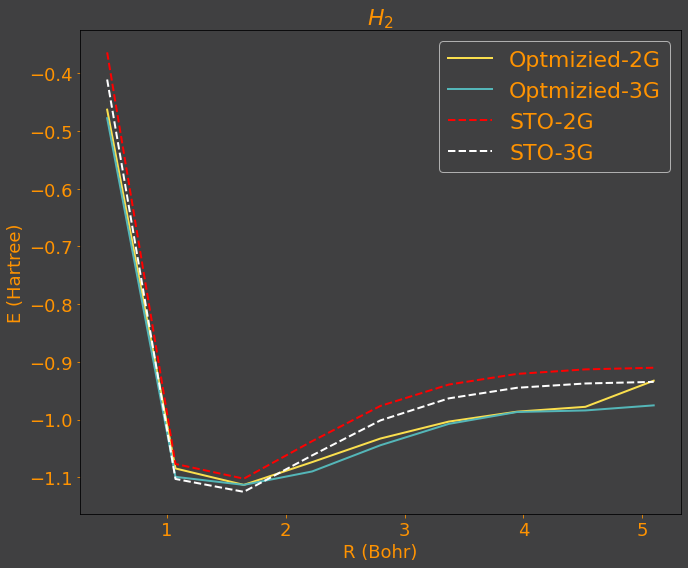

In [146]:
import matplotlib.pyplot as plt
colors = ['#54B6B8', '#FADF4E', 'pink', 'red']
bg = '#FF9301'
plt.rcParams['text.color'] = bg
plt.rcParams['axes.labelcolor'] = bg
plt.rcParams['xtick.color'] = bg
plt.rcParams['ytick.color'] = bg
lw = 2
fs = 22
sub_fs = 18
sz = 5
r1 = 0
r2 = -1
plt.figure(figsize=(10,8), facecolor='#404041')
plt.plot(distances[r1:r2], opt2g_scores[r1:r2], c=colors[1], label="Optmizied-2G", linewidth=lw)
plt.plot(distances[r1:r2], opt3g_scores[r1:r2], c=colors[0], label="Optmizied-3G", linewidth=lw)
plt.plot(distances[r1:r2], sto2g_scores[r1:r2], c='red', label="STO-2G", linestyle='--', linewidth=lw)
plt.plot(distances[r1:r2], sto3g_scores[r1:r2], c='white', label="STO-3G", linestyle='--', linewidth=lw)
plt.xticks(fontsize=sub_fs)
plt.yticks(fontsize=sub_fs)
plt.xlabel('R (Bohr)', fontsize=sub_fs)
plt.ylabel('E (Hartree)', fontsize=sub_fs)
plt.title("$H_2$", fontsize=fs)
plt.legend(fontsize=fs, facecolor='#404041')
plt.tight_layout()
ax = plt.gca()
ax.set_facecolor('#404041')
plt.subplots_adjust(left=0.15)
# plt.savefig('H2.png', facecolor='#404041', transparent=False, dpi=1200)